# Задача 9. Эксперименты: Статика vs. Динамика

В данном исследовании сравнивается производительность трёх алгоритмов, решающих задачу single source shortest path (SSSP):

1. Алгебраическая версия алгоритма Беллмана-Форда, реализованная при помощи GraphBLAS.
2. Классический алгоритм Дейкстры.
3. Динамический алгоритм, схожий по принципу работы с классическим алгоритмом Дейкстры.

Первые два алгоритма — статические, то есть решающие задачу сразу для всего графа целиком, а третий — динамический: в нём изначальные расстояния подсчитываются при помощи второго алгоритма, а при дальнейших обновлениях данная информация переиспользуется, чтобы не пересчитывать её в тех частях графа, которые точно не были затронуты обновлениями.

**Целью работы** является определение того, какой из алгоритмов-участников работает быстрее на каких размерах графов, с каким процентом изменившихся рёбер и каким способом их изменения (инкрементальным, когда рёбра только добавляются, декрементальным, когда они только удаляются, или смешанным).

In [1]:
import random
import time
import io
from itertools import zip_longest
from pathlib import Path
from typing import Hashable, Generator, Literal

import networkx as nx
import pandas as pd
import pygraphblas as gb
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

from project.shortest_path import sssp as gb_sssp
from project.shortest_path_dynamic import DynamicSSSP
from project.shortest_path_dynamic import dijkstra_sssp

## Оборудование

Далее представлены характеристики оборудования, на котором запускались эксперименты.

In [122]:
! printf '\n========== CPU ==========\n'
! lscpu | grep -E 'Architecture|Model name|Thread\(s\)|Core\(s\)|MHz'

! printf '\n========== RAM ==========\n'
! free -m


========== CPU ==========
Architecture:                    x86_64
Model name:                      AMD Ryzen 5 5600X 6-Core Processor
Thread(s) per core:              2
Core(s) per socket:              6

========== RAM ==========
               total        used        free      shared  buff/cache   available
Mem:            7917        2441        5053           0         422        5236
Swap:           2048           0        2048


## Генерация графов

В экспериментах используются пять категорий графов по числу вершин: до 100, 1000, 5000, 10000, 25000, 50000, 100000 вершин.

В каждой категории находится по три графа, чтобы полученные на них результаты времени работы алгоритмов можно было усреднить. Большее число графов сгенерировано не было, так как уже при таком количестве на использованном оборудовании замеры занимают несколько часов.

Графы генерировались средствами, доступными в `networkx`. В первую категорию вошли графы [из области социальных сетей](https://networkx.org/documentation/stable/reference/generators.html#module-networkx.generators.social), так как их размеры как раз не превышают 100 вершин. Для всех остальных категорий использовался генератор [`gaussian_random_partition_graph`](https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.gaussian_random_partition_graph.html#networkx.generators.community.gaussian_random_partition_graph), так как, во-первых, его параметры легко интерпретировать, во-вторых, части графа, генерируемого им, как правило, достижимы друг из друга (а значит, меньше шанс начать решать задачу SSSP лишь на изолированном подграфе), а в-третьих, он имеет относительно высокую скорость генерации больших графов.

Параметры `gaussian_random_partition_graph` выбирались так, чтобы с увеличением исла вершин росло и число рёбер (так как мы хотим протестировать как большее число вершин, так и большее число рёбер), а также, чтобы внутри "сообществ" рёбра встречались чаще, чем вне них (так как это соответствует пониманию о том, что такое "сообщество").

Было решено сериализовывать графы для последующего использования, однако, как оказалось, десериализовывать их не то что бы заметно быстрее, чем генерировать заново.

In [124]:
graphs_dir = Path("graphs")


def generate_and_save_graphs():
    graphs_dir.mkdir(exist_ok=True)

    print("<100 vertices:")
    for i, g in enumerate(
            [
                nx.karate_club_graph().to_directed(),
                nx.davis_southern_women_graph().to_directed(),
                nx.les_miserables_graph().to_directed(),
            ],
            start=1,
    ):
        print(f"{i}.", g)
        nx.write_gexf(g, graphs_dir / f"100_{i}.txt")
    print()

    def generate_larger_graphs(n_vertices: int) -> Generator[nx.DiGraph, None, None]:
        base_prob = 0.01 if n_vertices <= 25000 else 0.001

        yield nx.gaussian_random_partition_graph(
            n_vertices, 1000, 3, base_prob * 4, base_prob / 2, directed=True, seed=1
        )
        yield nx.gaussian_random_partition_graph(
            n_vertices, n_vertices / 100, 3, base_prob, base_prob / 10, directed=True, seed=1
        )
        yield nx.gaussian_random_partition_graph(
            n_vertices, n_vertices / 50, 3, base_prob / 10, base_prob / 20, directed=True, seed=1
        )

    for n_vertices in [1000, 5000, 10000, 25000, 50000, 100000]:
        print(f"{n_vertices} vertices:")
        for i, g in enumerate(generate_larger_graphs(n_vertices), start=1):
            print(f"{i}.", g)
            nx.write_gexf(g, graphs_dir / f"{n_vertices}_{i}.txt")
        print()


# Uncomment to re-generate the graphs
generate_and_save_graphs()

<100 vertices:
1. DiGraph named "Zachary's Karate Club" with 34 nodes and 156 edges
2. DiGraph with 32 nodes and 178 edges
3. DiGraph with 77 nodes and 508 edges

1000 vertices:
1. DiGraph named 'stochastic_block_model' with 1000 nodes and 39819 edges
2. DiGraph named 'stochastic_block_model' with 1000 nodes and 1113 edges
3. DiGraph named 'stochastic_block_model' with 1000 nodes and 525 edges

5000 vertices:
1. DiGraph named 'stochastic_block_model' with 5000 nodes and 333610 edges
2. DiGraph named 'stochastic_block_model' with 5000 nodes and 27512 edges
3. DiGraph named 'stochastic_block_model' with 5000 nodes and 12703 edges

10000 vertices:
1. DiGraph named 'stochastic_block_model' with 10000 nodes and 861667 edges
2. DiGraph named 'stochastic_block_model' with 10000 nodes and 109692 edges
3. DiGraph named 'stochastic_block_model' with 10000 nodes and 50792 edges

25000 vertices:
1. DiGraph named 'stochastic_block_model' with 25000 nodes and 4102903 edges
2. DiGraph named 'stochast

## Проведение экспериментов

Для каждого графа, для каждого процента изменившихся рёбер и для каждого способа их изменения подсчитывалось время работы каждого из исследуемых алгоритмов.

Для статических алгоритмов подсчитывалось время работы на уже изменённом графе, а для динамического — время первого запроса после проведения всех изменений.

Для алгоритма, основанного на GraphBLAS, не учитывалось время перевода представления графа в GraphBLAS-матрицу смежности, так как на практике, если использовать данных алгоритм, то эффективнее будет сразу хранить граф в таком представлении, то есть время на перевод затрачивать не придётся.

Было решено, что включать во время работы динамического алгоритма первоначальную обработку графа некорректно, так как, тогда бы и для статических алгоритмов стоило включать время их работы на начальном графе, что выглядит излишним, так как нас интересует именно время работы на конечном графе. Время, затрачиваемое на изменение графа через объект динамического алгоритма, также не учитывалось, так как, во-первых, оно по своей сути включает лишь изменение структуры графа, то есть сильно зависит от реализации этой самой структуры, а во-вторых, для статических алгоритмов это время также не подсчитывается, хотя на практике оно и будет затрачено.

При смешанных обновлениях добавления и удаления рёбер для динамического алгоритма чередовались, однако, не ожидается, что порядок данных обновлений на что-либо повлияет, так как алгоритм обрабатывает их все одновременно при первом запросе.

In [2]:
modified_edges_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
results_file = Path("results.csv")

random.seed(1)


def save_result(
        algo: Literal["GraphBLAS", "Dijkstra", "Dynamic"],
        run_type: Literal["Inc", "Dec", "Mix"],
        n_vertices: int,
        modified_edges_ratio: float,
        time_sec: float,
):
    res_str = f"{algo},{run_type},{n_vertices},{modified_edges_ratio},{time_sec}"
    with open(results_file, "a") as f:
        f.write(res_str + "\n")
    print(f"Saved: {res_str}")


def run_gb_sssp(graph: nx.DiGraph, start: Hashable) -> float:
    graph_mat = gb.Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(graph).astype(float, copy=False))
    # Graph matrix must have explicit zeroes on the main diagonal, since no-value is treated as +inf
    graph_mat.eadd(gb.Matrix.identity(gb.FP64, graph_mat.nrows, value=0), out=graph_mat)

    start_i = list(graph).index(start)

    t1 = time.perf_counter()
    gb_sssp(graph_mat, start_i)
    t2 = time.perf_counter()

    return t2 - t1


def run_dijkstra_sssp(graph: nx.Graph, start: Hashable) -> float:
    t1 = time.perf_counter()
    dijkstra_sssp(graph, start)
    t2 = time.perf_counter()
    return t2 - t1


def run_experiments():
    for g_file_path in sorted(graphs_dir.iterdir(), key=lambda p: [int(x) for x in p.stem.split("_")]):
        print(f"Loading {g_file_path}")
        g_orig: nx.DiGraph = nx.read_gexf(g_file_path)
        start = random.sample(list(g_orig.nodes), 1)[0]
        print(f"Loaded {g_orig}, start = {start}")

        for modified_edges_ratio in modified_edges_ratios:
            edges_to_modify = random.sample(
                list(g_orig.edges), int(g_orig.number_of_nodes() * modified_edges_ratio)
            )
            edges_to_keep = g_orig.edges - edges_to_modify
            print(f"Ratio {modified_edges_ratio}: {len(edges_to_modify)} modified edges")

            # Incremental: static SSSPs

            t = run_gb_sssp(g_orig, start)
            save_result("GraphBLAS", "Inc", g_orig.number_of_nodes(), modified_edges_ratio, t)

            t = run_dijkstra_sssp(g_orig, start)
            save_result("Dijkstra", "Inc", g_orig.number_of_nodes(), modified_edges_ratio, t)

            # Incremental: dynamic SSSP

            g = nx.DiGraph()
            g.add_nodes_from(g_orig.nodes)
            g.add_nodes_from(edges_to_keep)

            algo = DynamicSSSP(g, start)
            for u, v in edges_to_modify:
                algo.insert_edge(u, v)

            t1 = time.perf_counter()
            algo.query_dists()
            t2 = time.perf_counter()
            save_result("Dynamic", "Inc", g_orig.number_of_nodes(), modified_edges_ratio, t2 - t1)
            del algo

            # Decremental: static SSSPs

            g = nx.DiGraph()
            g.add_nodes_from(g_orig.nodes)
            g.add_edges_from(edges_to_keep)

            t = run_gb_sssp(g, start)
            save_result("GraphBLAS", "Dec", g_orig.number_of_nodes(), modified_edges_ratio, t)

            t = run_dijkstra_sssp(g, start)
            save_result("Dijkstra", "Dec", g_orig.number_of_nodes(), modified_edges_ratio, t)

            # Decremental: dynamic SSSP

            g = g_orig.copy()

            algo = DynamicSSSP(g, start)
            for u, v in edges_to_modify:
                algo.delete_edge(u, v)

            t1 = time.perf_counter()
            algo.query_dists()
            t2 = time.perf_counter()
            save_result("Dynamic", "Dec", g_orig.number_of_nodes(), modified_edges_ratio, t2 - t1)
            del algo

            # Mixed
            edges_to_insert = edges_to_modify[:len(edges_to_modify) // 2]
            edges_to_delete = edges_to_modify[len(edges_to_modify) // 2:]

            # Mixed: static SSSPs

            g = nx.DiGraph()
            g.add_nodes_from(g_orig.nodes)
            g.add_edges_from(g_orig.edges - edges_to_delete)

            t = run_gb_sssp(g, start)
            save_result("GraphBLAS", "Mix", g_orig.number_of_nodes(), modified_edges_ratio, t)

            t = run_dijkstra_sssp(g, start)
            save_result("Dijkstra", "Mix", g_orig.number_of_nodes(), modified_edges_ratio, t)

            # Mixed: dynamic SSSP

            g = nx.DiGraph()
            g.add_nodes_from(g_orig.nodes)
            g.add_edges_from(g_orig.edges - edges_to_insert)

            algo = DynamicSSSP(g, start)
            for e_ins, e_del in zip_longest(edges_to_insert, edges_to_delete):
                if e_ins is not None:
                    algo.insert_edge(*e_ins)
                if e_del is not None:
                    algo.delete_edge(*e_del)

            t1 = time.perf_counter()
            algo.query_dists()
            t2 = time.perf_counter()
            save_result("Dynamic", "Mix", g_orig.number_of_nodes(), modified_edges_ratio, t2 - t1)
            del algo

        print()

In [ ]:
run_experiments()

## Результаты замеров

В таблице и на графиках ниже представлены полученные результаты.

Можно отметить, что во всех случаях алгоритм, использующий GraphBLAS, показывает себя хуже, чем два других алгоритма. Причем, при увеличении числа вершин разрыв очень быстро увеличивается. Это можно объяснить тем, что с ростом числа вершин аналогично растут как размеры матриц, которыми алгоритм манипулирует (в случае со сгенерированными графами также растёт и число рёбер, то есть, непустых элементов матриц), так и число шагов, то есть количества умножений, производимых алгоритмом Беллмана-Форда (в используемой реализации нет предварительной остановки в случае, если матрица перестаёт изменяться).

При инкрементальных обновлениях, то есть, когда рёбра лишь добавляются, динамический алгоритм имеет наилучшее время работы при любых размерах вершин и множества добавленных рёбер.

При декрементальных и смешанных обновлениях динамический алгоритм показывает себя хуже, чем при инкрементальных. Он обгоняет классический алгоритм Дейкстры лишь на небольших графах или при небольшом количестве изменившихся рёбер. В остальных случаях же он ведёт себя так же или хуже. Можно лишь предположить, что это объясняется структурой используемых графов: удаления рёбер влекут больше изменений, чем их добавления, и динамическому алгоритму приходится пересчитывать больше путей.

In [115]:
results = pd.read_csv(results_file, names=["Algorithm", "Updates type", "Number of vertices", "Modified edges fraction", "Time, s"])
results_grouped = results
results_grouped["Number of vertices"] = results["Number of vertices"].apply(lambda n: str(n) if n >= 1000 else "<100")
results_grouped

,Algorithm,Updates type,Number of vertices,Modified edges fraction,"Time, s"
0,GraphBLAS,Inc,<100,0.1,0.000444
1,Dijkstra,Inc,<100,0.1,0.000141
2,Dynamic,Inc,<100,0.1,0.000024
3,GraphBLAS,Dec,<100,0.1,0.000226
4,Dijkstra,Dec,<100,0.1,0.000109
...,...,...,...,...,...
940,Dijkstra,Dec,100000,0.5,0.738414
941,Dynamic,Dec,100000,0.5,3.896285
942,GraphBLAS,Mix,100000,0.5,76.981911
943,Dijkstra,Mix,100000,0.5,0.751187


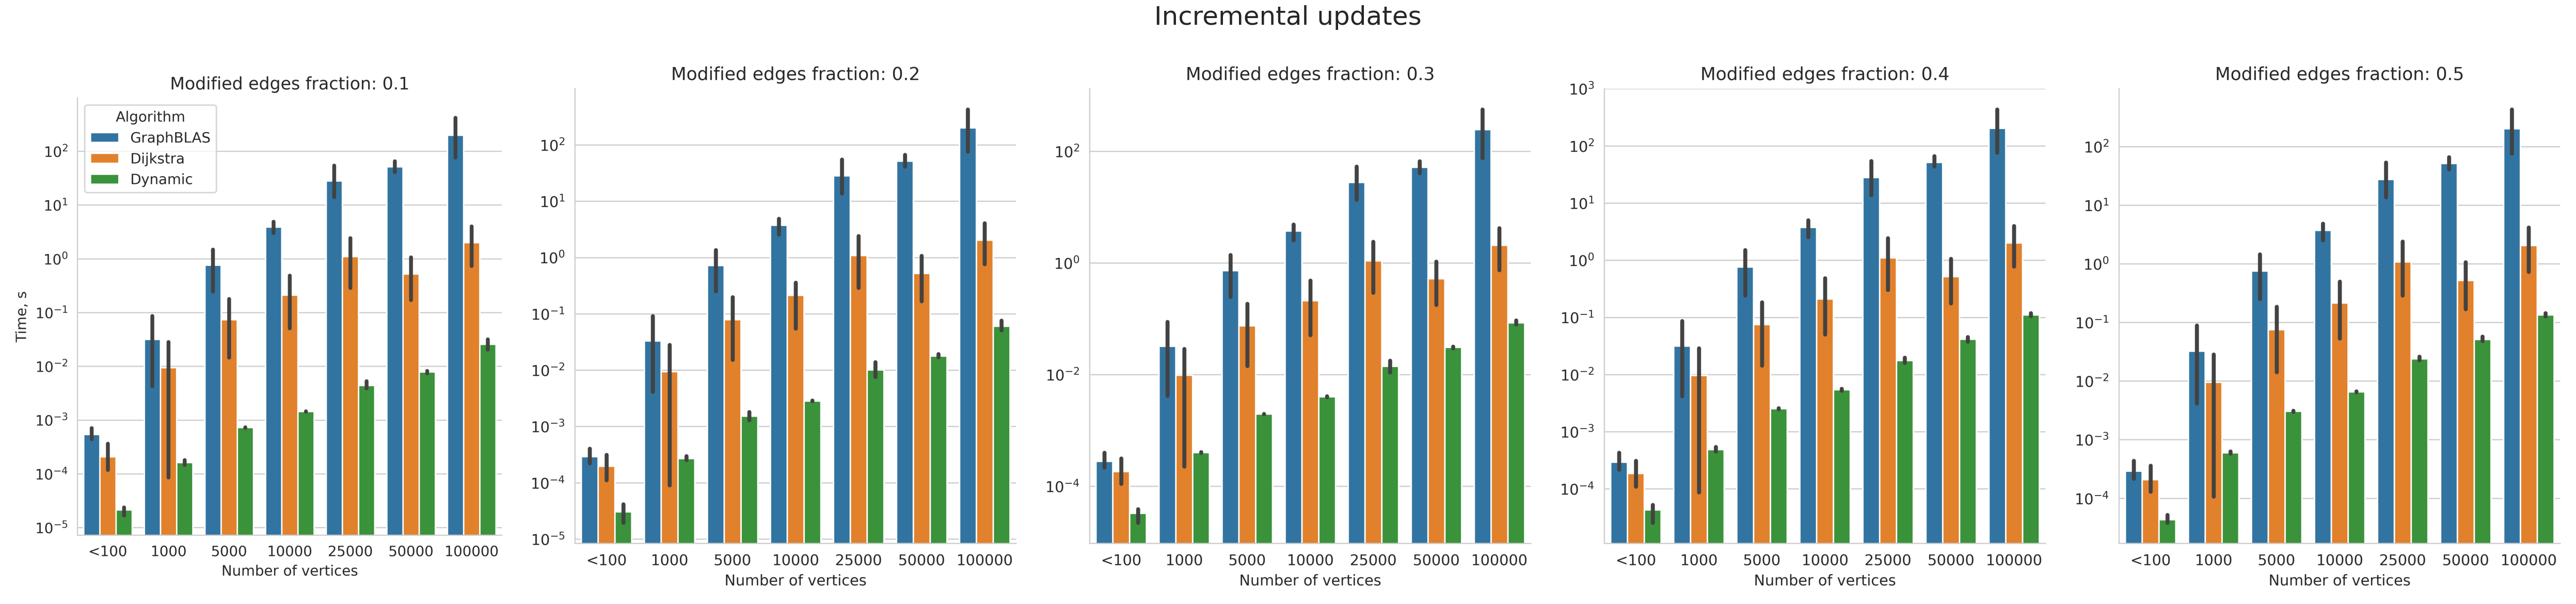

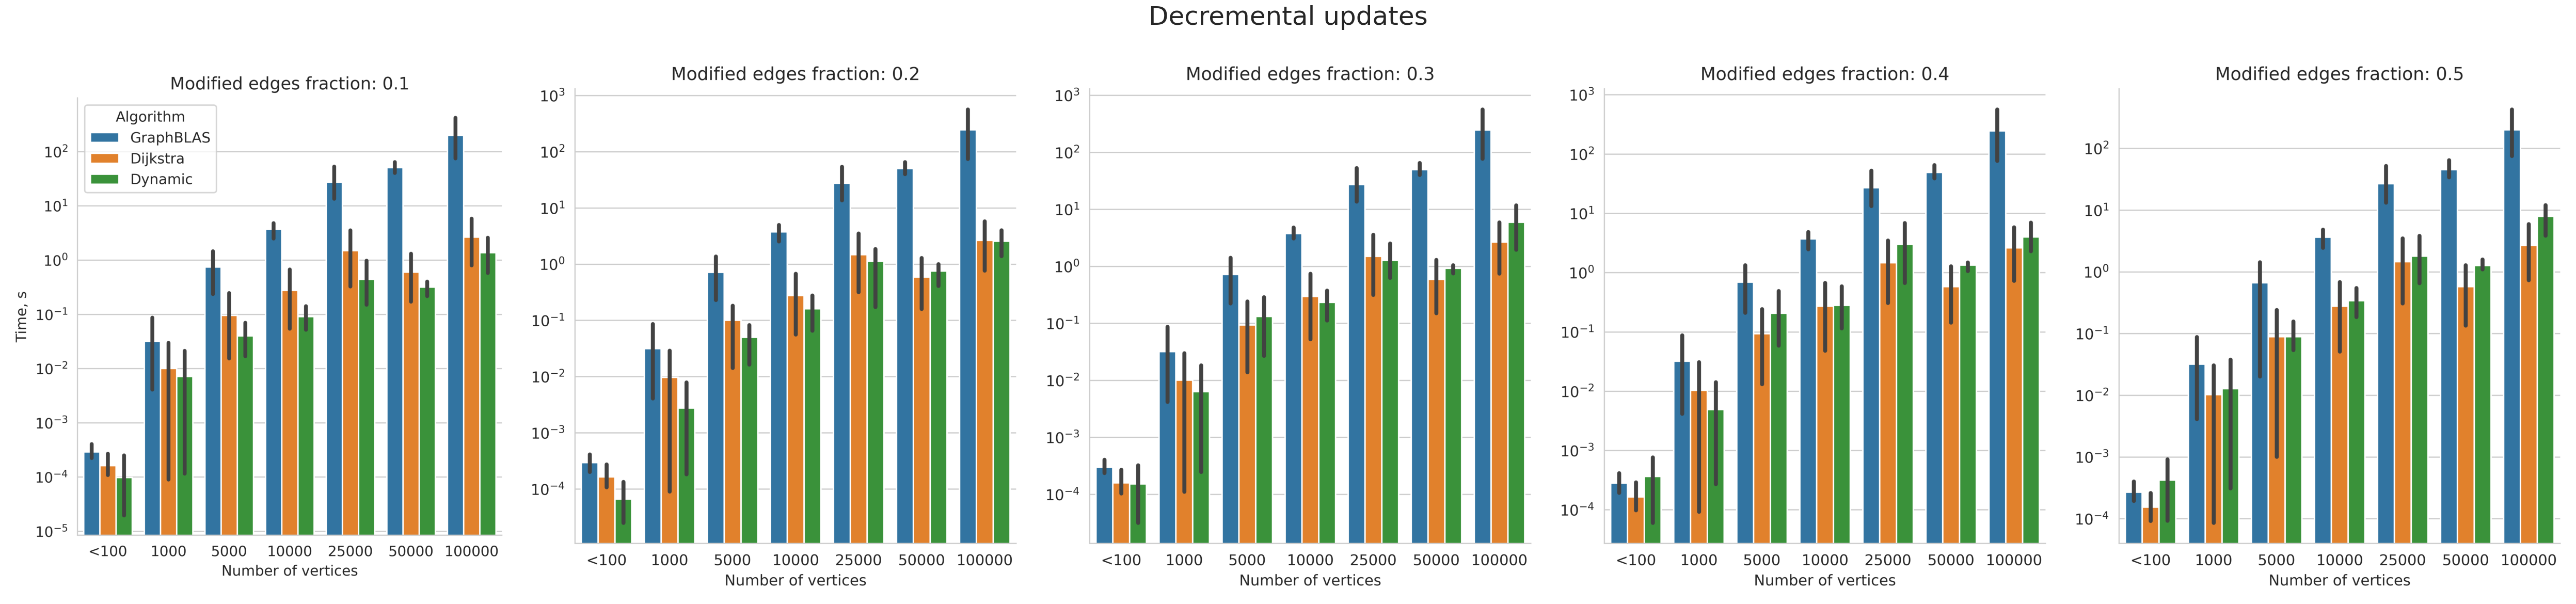

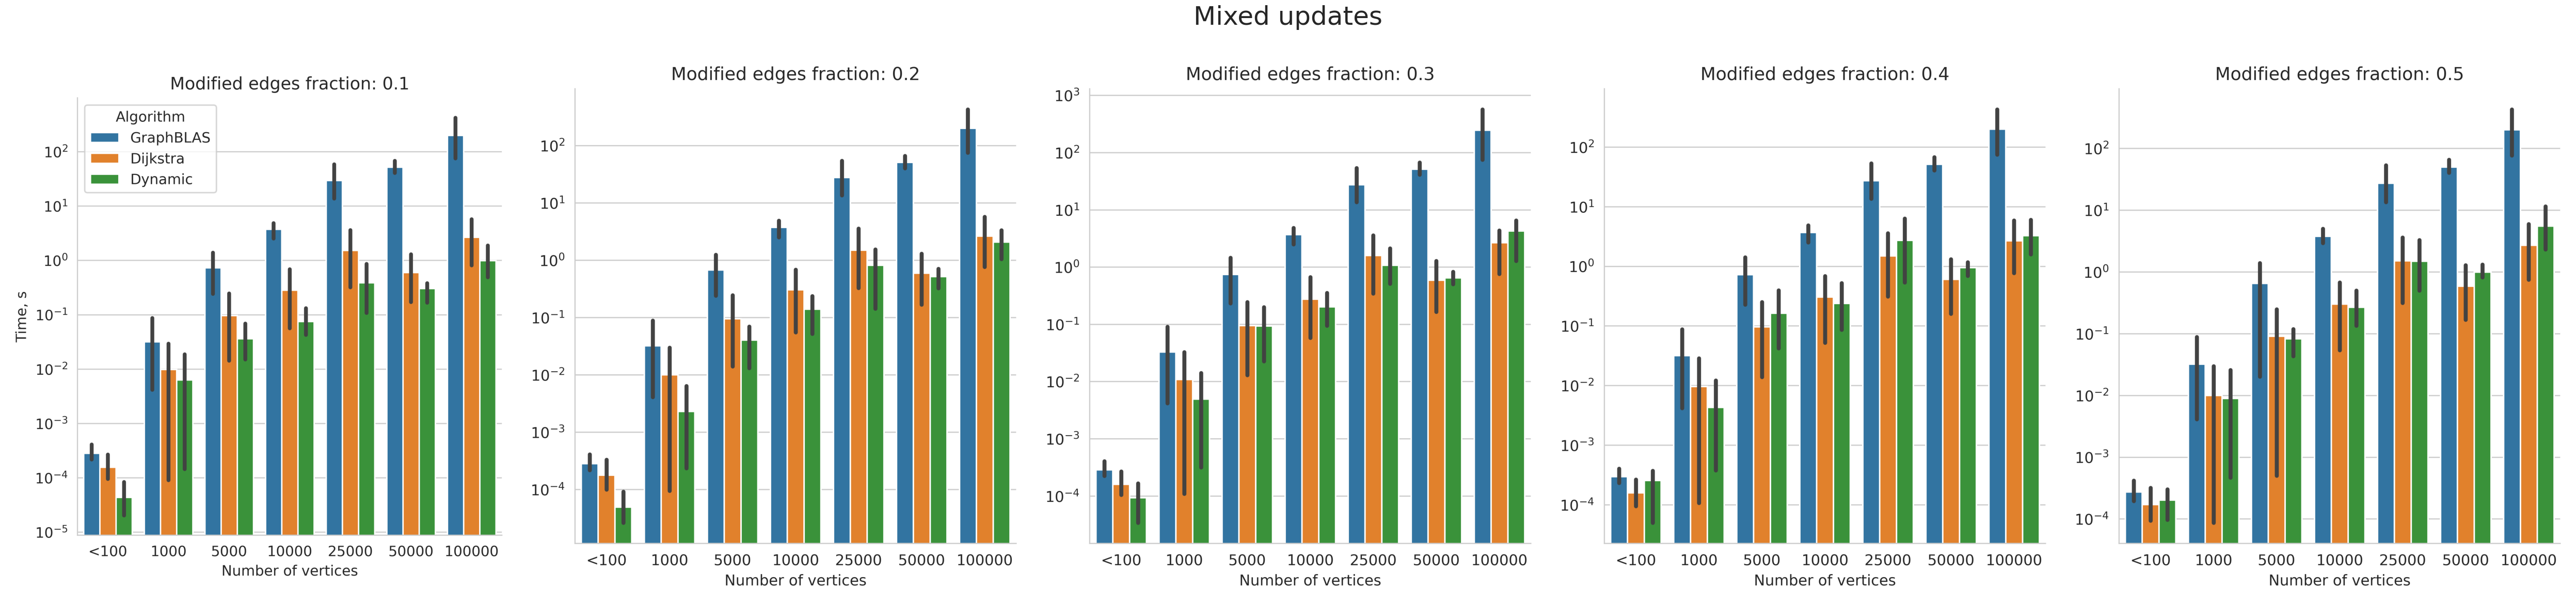

In [117]:
# A hacky way to show several catplots in a row, since they cannot be placed in subplots
def grid_to_image(grid: sns.FacetGrid) -> Image.Image:
    buf = io.BytesIO()
    grid.figure.savefig(buf, format="png", dpi=500, bbox_inches="tight")
    return Image.open(buf)


def show_detailed_plots():
    for updates_type in ["Incremental", "Decremental", "Mixed"]:
        plot_images = []
        for fraction in modified_edges_ratios:
            grid = sns.catplot(
                results_grouped[
                    (results_grouped["Updates type"] == updates_type[:3]) &
                    (results_grouped["Modified edges fraction"] == fraction)
                ],
                kind="bar",
                x="Number of vertices",
                y="Time, s",
                hue="Algorithm",
                legend=fraction == modified_edges_ratios[0],
                legend_out=False,
            )
            plt.title(f"Modified edges fraction: {fraction}")
            plt.yscale("log")

            if fraction != modified_edges_ratios[0]:
                grid.set_ylabels("")

            plot_images.append(grid_to_image(grid))
            plt.close()  # Removes the figure created by catplot

        fig, axs = plt.subplots(
            ncols=len(modified_edges_ratios),
            figsize=(len(modified_edges_ratios) * 10, len(modified_edges_ratios) * 5),
        )
        for ax, plot_image in zip(axs, plot_images):
            ax.imshow(plot_image)
            ax.axis("off")
        fig.tight_layout()

        fig.suptitle(f"{updates_type} updates", y=0.75, size=36)


def show_compact_plots():
    plot_images = []
    for updates_type in ["Incremental", "Decremental", "Mixed"]:
        grid = sns.catplot(
            results_grouped[results_grouped["Updates type"] == updates_type[:3]],
            kind="bar",
            x="Number of vertices",
            y="Time, s",
            hue="Algorithm",
            legend=updates_type == "Incremental",
            legend_out=False,
        )
        plt.title(f"{updates_type} updates")
        plt.yscale("log")

        if updates_type != "Incremental":
            grid.set_ylabels("")

        plot_images.append(grid_to_image(grid))
        plt.close()  # Removes the figure created by catplot

    fig, axs = plt.subplots(ncols=3, figsize=(24, 8))
    for ax, plot_image in zip(axs, plot_images):
        ax.imshow(plot_image)
        ax.axis("off")
    fig.tight_layout()


# Uncomment to see a more compact representation instead: plots for different fractions will be unified
show_detailed_plots()
# show_compact_plots()

## Выводы

Исходя из полученных результатов, можно сделать следующие выводы:
1. Приведённая реализация алгоритма, использующая GraphBLAS, работает в десятки, а то и стони раз медленнее двух других рассмотренных реализаций алгоритмов на всех размерах графа и множества изменившихся рёбер. Причем, с увеличением размера графа отставание увеличивается.
2. При инкрементальных обновлениях исследуемый динамический алгоритм работает быстрее остальных во всех рассмотренных случаях. В среднем при инкрементальных обновлениях он работает примерно в 10 раз быстрее классического алгоритма Дейкстры.
3. При декрементальных и смешанных обновлениях динамический алгоритм работает на десятитысячные доли секунды быстрее классического алгоритма Дейкстры на маленьких графах и множествах изменившихся рёбер и на секунды медленнее — на больших.